In [ ]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading.requests import GetAssetsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import pandas as pd
import os

# Keys
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

stock_client = StockHistoricalDataClient(API_KEY,  SECRET_KEY)


stock = "AAPL"
request_params = StockBarsRequest(symbol_or_symbols=[stock], timeframe=TimeFrame.Minute, start=datetime(2000, 3, 11), end=datetime(2025, 1, 1))
bars = stock_client.get_stock_bars(request_params)

# Flatten the dictionary into a DataFrame
df = pd.DataFrame(bars[stock])

# Extrahera endast värdena från tuple-paren
df = df.map(lambda x: x[1])  # Tar bara det andra elementet i tuple:n

# Sätt kolumnnamn
df.columns = ["symbol", "timestamp", "open", "high", "low", "close", "volume", "trade_count", "vwap"]

In [152]:
import pandas as pd
import numpy as np

df_features = df.copy()

# 🟢 Exponentiella glidande medelvärden (EMA)
df_features["EMA_9"] = df_features["close"].ewm(span=9, adjust=False).mean()
df_features["EMA_21"] = df_features["close"].ewm(span=21, adjust=False).mean()

# 🟢 Enkel glidande medelvärden (SMA)
df_features["SMA_50"] = df_features["close"].rolling(window=50).mean()
df_features["SMA_200"] = df_features["close"].rolling(window=200).mean()

# 🟢 MACD & Signal Line
df_features["MACD"] = df_features["EMA_9"] - df_features["EMA_21"]
df_features["Signal_Line"] = df_features["MACD"].ewm(span=9, adjust=False).mean()

# 🟢 RSI (Relative Strength Index)
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_features["RSI_14"] = calculate_rsi(df_features["close"])

# 🟢 VWAP (Volume Weighted Average Price)
df_features["VWAP"] = (df_features["vwap"] * df_features["volume"]).cumsum() / df_features["volume"].cumsum()

# 🟢 Volymförändring (% skillnad)
df_features["Volume_Change"] = df_features["volume"].pct_change()

# 🟢 Prisskillnad (log-return för stabilare träning)
df_features["Return"] = np.log(df_features["close"] / df_features["close"].shift(1))

# 🟢 Lag-features (Senaste 3 stängningspriser)
df_features["Close_Lag_1"] = df_features["close"].shift(1)
df_features["Close_Lag_2"] = df_features["close"].shift(2)
df_features["Close_Lag_3"] = df_features["close"].shift(3)

# 🟢 Målvariabel (Target Variable)
df_features["future_return"] = df_features["close"].pct_change(5).shift(-5)  # 5 perioder framåt
threshold = 0.01  # 0.5% förändring som gräns

# Justera målvärdena så de passar XGBoost (0 = håll, 1 = köp, 2 = sälj)
df_features["target"] = 0  # Håll som standard
df_features.loc[df_features["future_return"] > threshold, "target"] = 1  # Köp
df_features.loc[df_features["future_return"] < -threshold, "target"] = 2  # Sälj

# Ta bort rader med NaN-värden efter beräkning av indikatorer
df_features.dropna(inplace=True)

# Visa resultatet
df_features.head()


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,EMA_9,...,Signal_Line,RSI_14,VWAP,Volume_Change,Return,Close_Lag_1,Close_Lag_2,Close_Lag_3,future_return,target
199,AAPL,2016-01-04 13:54:00+00:00,102.89,103.00,102.88,102.97,11884.0,47.0,102.942796,102.911487,...,-0.088565,35.0000,103.247044,1.783138,0.001166,102.85,102.80,102.82,0.000291,0
200,AAPL,2016-01-04 13:55:00+00:00,102.98,103.00,102.91,102.93,3783.0,24.0,102.937351,102.915189,...,-0.086577,32.8125,103.244991,-0.681673,-0.000389,102.97,102.85,102.80,-0.000194,0
201,AAPL,2016-01-04 13:56:00+00:00,102.94,102.94,102.90,102.90,6025.0,16.0,102.932536,102.912152,...,-0.083888,32.8125,103.241727,0.592651,-0.000292,102.93,102.97,102.85,0.000000,0
202,AAPL,2016-01-04 13:57:00+00:00,102.92,102.95,102.92,102.95,3378.0,19.0,102.937910,102.919721,...,-0.079581,40.0000,103.239958,-0.439336,0.000486,102.90,102.93,102.97,-0.000194,0
203,AAPL,2016-01-04 13:58:00+00:00,102.91,102.95,102.91,102.95,2092.0,9.0,102.935888,102.925777,...,-0.074342,39.0625,103.238865,-0.380699,0.000000,102.95,102.90,102.93,-0.000486,0


In [153]:
import pandas as pd
from sklearn.utils import resample

print(df_features['target'].value_counts())

# Dela upp dataframe i tre klasser: 0, 1 och 2
df_class_0 = df_features[df_features['target'] == 0]
df_class_1 = df_features[df_features['target'] == 1]
df_class_2 = df_features[df_features['target'] == 2]

# Upsample de minoritetsklasserna så att deras antal matchar majoritetsklassen (target=0)
df_class_1_upsampled = resample(df_class_1, 
                                 replace=True,     # Tillåter duplicering
                                 n_samples=len(df_class_0),    # Målet är att matcha storleken på class_0
                                 random_state=42)  # För reproducerbarhet

df_class_2_upsampled = resample(df_class_2, 
                                 replace=True,
                                 n_samples=len(df_class_0),
                                 random_state=42)

# Kombinera tillbaka de resamplade klasserna
df_balanced = pd.concat([df_class_0, df_class_1_upsampled, df_class_2_upsampled])

# Slumpa om raderna för att blanda datasetet
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Visa det balanserade datasetet
print(df_balanced['target'].value_counts())

target
0    1596480
1       1579
2       1536
Name: count, dtype: int64
target
2    1596480
1    1596480
0    1596480
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Features och target
X = df_balanced.drop(columns=["target", "timestamp", "symbol", "future_return"])  # Ta bort kolumner som inte är användbara för träning
y = df_balanced["target"]

# Dela upp i tränings- och testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # shuffle=False för tidsserie

In [155]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Scale för att balansera datasettet
target_counts = df_balanced['target'].value_counts()
num_0 = target_counts[0]  # Håll

# Beräkna vikterna för varje klass
weights = df_balanced['target'].map(lambda x: num_0 / target_counts[x])

# Skapa DMatrix med vikter
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights[:len(X_train)])  # Vikterna för träningsdata
dtest = xgb.DMatrix(X_test, label=y_test)

# Definiera hyperparametrar för XGBoost utan scale_pos_weight
params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "mlogloss",
}

# Träna modellen
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Spara modellen
modell_name = stock + "_model.model"
model.save_model(modell_name)

# Prediktera på testsetet
y_pred = model.predict(dtest)

# Om du har fler än två klasser, använd round för att omvandla prediktioner till klasser
y_pred = y_pred.round()

# Utvärdera modellen
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Hämta feature importance
importance = model.get_score(importance_type='weight')  # 'weight' visar hur ofta en feature används

# Sortera funktionerna efter betydelse
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Visa de viktigaste funktionerna
for feature, score in sorted_importance:
    print(f"Feature: {feature}, Score: {score}")



C:\Users\aolivest\AppData\Local\Temp\ipykernel_22876\2611270200.py:32: UserWarning: [16:35:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  model.save_model(modell_name)


Accuracy: 0.8811353728202045
              precision    recall  f1-score   support

           0       0.85      0.85      0.85    318618
           1       0.90      0.90      0.90    319227
           2       0.89      0.89      0.89    320043

    accuracy                           0.88    957888
   macro avg       0.88      0.88      0.88    957888
weighted avg       0.88      0.88      0.88    957888

Feature: VWAP, Score: 1982.0
Feature: volume, Score: 1567.0
Feature: trade_count, Score: 1542.0
Feature: Return, Score: 1359.0
Feature: Signal_Line, Score: 1290.0
Feature: MACD, Score: 1198.0
Feature: RSI_14, Score: 1125.0
Feature: Volume_Change, Score: 978.0
Feature: SMA_200, Score: 799.0
Feature: open, Score: 517.0
Feature: SMA_50, Score: 508.0
Feature: high, Score: 355.0
Feature: low, Score: 342.0
Feature: EMA_21, Score: 313.0
Feature: EMA_9, Score: 210.0
Feature: close, Score: 208.0
Feature: Close_Lag_3, Score: 164.0
Feature: vwap, Score: 162.0
Feature: Close_Lag_2, Score: 152.0


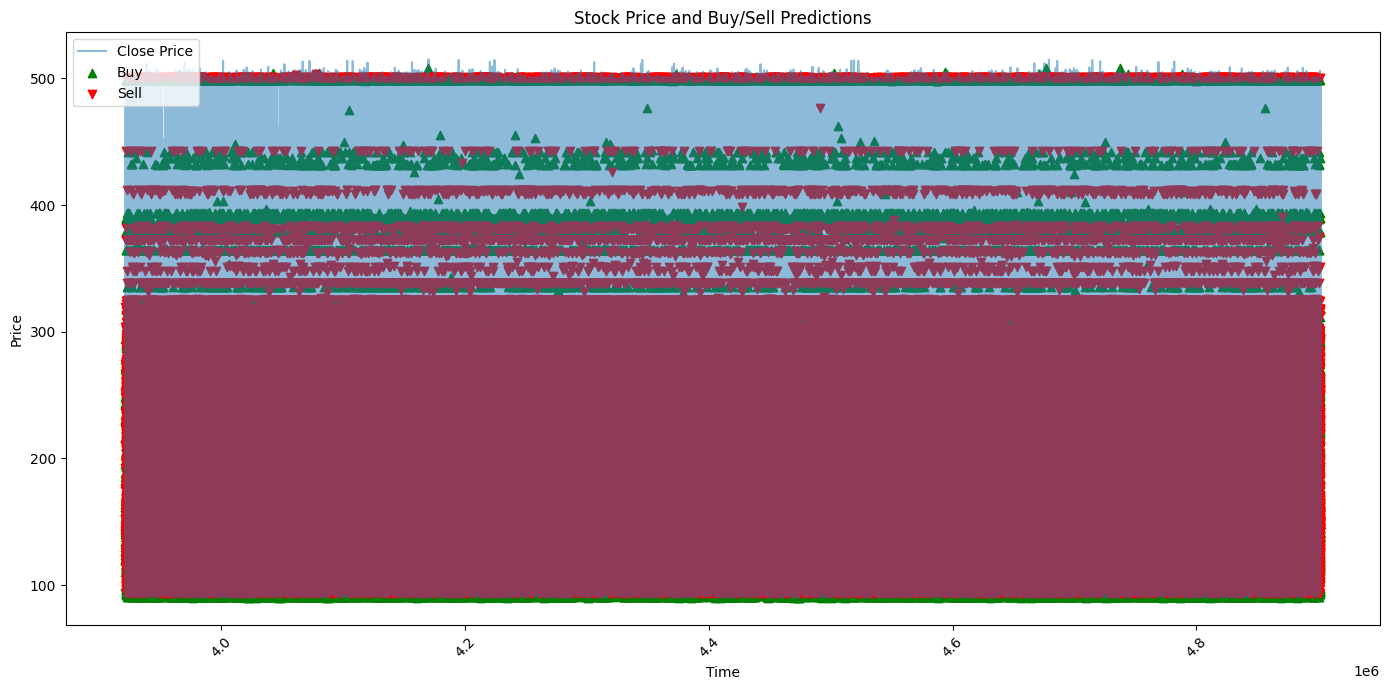

In [144]:
import matplotlib.pyplot as plt

# Skapa DataFrame för att plotta
df_plot = pd.DataFrame({
    "timestamp": df_features["timestamp"].iloc[len(X_train):len(X_train) + len(y_test)],  # Tidsstämplar för testdata
    "actual": y_test,
    "predicted": y_pred,
    "close": df_features["close"].iloc[len(X_train):len(X_train) + len(y_test)]  # Stängningspriser
})

# Plotta stängningspriser och andra linjer (t.ex. EMA) om du vill inkludera dem
plt.figure(figsize=(14, 7))
plt.plot(df_plot["close"], label="Close Price", alpha=0.5)

# Plotta köp- och sälj-signaler
plt.scatter(df_plot.index[df_plot["predicted"] == 1], df_plot["close"][df_plot["predicted"] == 1], marker="^", color="g", label="Buy", alpha=1)
plt.scatter(df_plot.index[df_plot["predicted"] == 2], df_plot["close"][df_plot["predicted"] == 2], marker="v", color="r", label="Sell", alpha=1)

# Anpassa diagrammet
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price and Buy/Sell Predictions')
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.tight_layout()

# Visa plotten
plt.show()


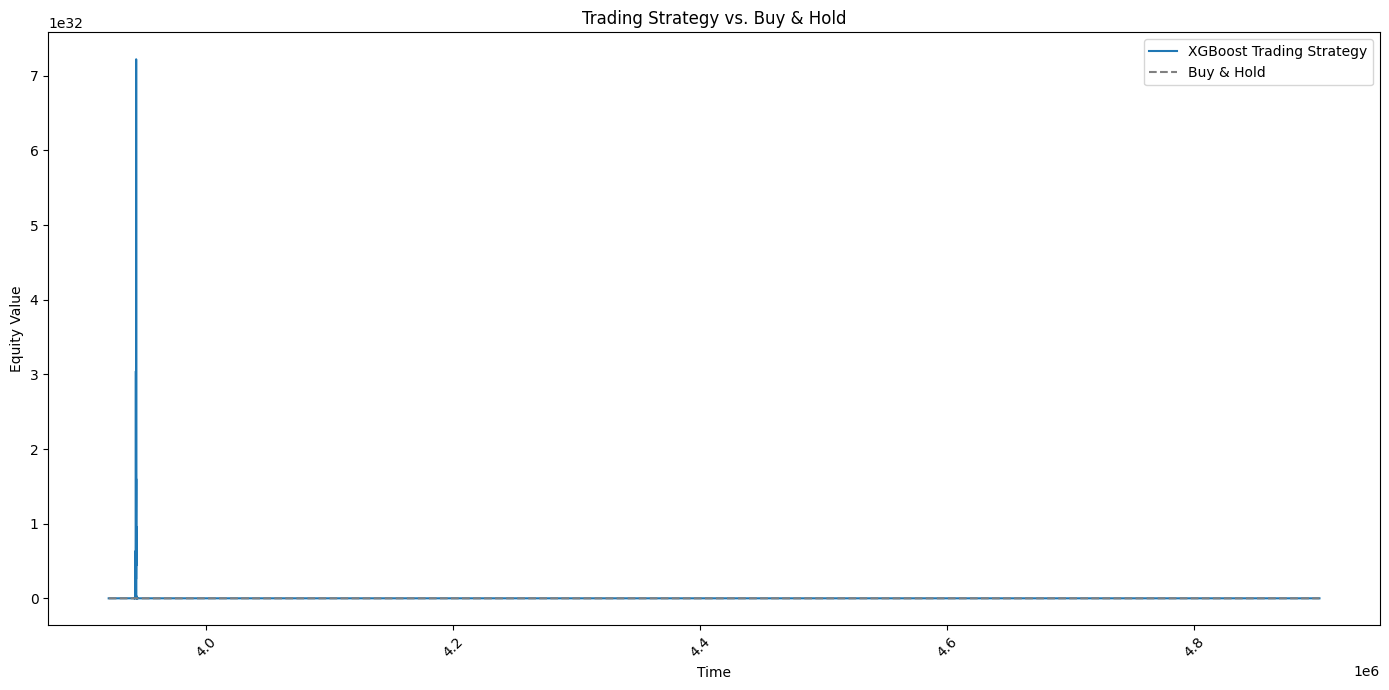

In [145]:
initial_capital = 10000  # Startkapital
position = 0  # 1 = Inne i en trade, 0 = Utanför
capital = initial_capital
returns = []
buy_and_hold_position = initial_capital / df_plot["close"].iloc[0]
buy_and_hold = []

# Testa tradingstrategin baserat på XGBoost-prediktioner (1 = Köp, 2 = Sälj)
for i in range(len(df_plot)):
    if df_plot["predicted"].iloc[i] == 1 and position == 0:  # Köp
        position = capital / df_plot["close"].iloc[i]  # Antal aktier
        capital = 0  # Vi har investerat allt
    elif df_plot["predicted"].iloc[i] == 2 and position > 0:  # Sälj
        capital = position * df_plot["close"].iloc[i]  # Sälj allt
        position = 0  # Vi har sålt
    returns.append(capital + (position * df_plot["close"].iloc[i]))  # Värde av position
    buy_and_hold.append(buy_and_hold_position * df_plot["close"].iloc[i])  # Köp och håll strategi

# Lägg till strategins värde och köp-och-håll-värde som kolumner i DataFrame
df_plot["Strategy Equity"] = returns
df_plot["Buy & Hold Equity"] = buy_and_hold

# Plotta equity curve
plt.figure(figsize=(14, 7))
plt.plot(df_plot["Strategy Equity"], label="XGBoost Trading Strategy")
plt.plot(df_plot["Buy & Hold Equity"], linestyle="dashed", color="gray", label="Buy & Hold")
plt.xlabel('Time')
plt.ylabel('Equity Value')
plt.title('Trading Strategy vs. Buy & Hold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [169]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading.requests import GetAssetsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import pandas as pd
import os

# Keys
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

stock_client = StockHistoricalDataClient(API_KEY,  SECRET_KEY)


stock = "AAPL"
request_params = StockBarsRequest(symbol_or_symbols=[stock], timeframe=TimeFrame.Minute, start=datetime(2025, 1, 1), end=datetime(2025, 3, 16))
bars = stock_client.get_stock_bars(request_params)

# Flatten the dictionary into a DataFrame
df_test = pd.DataFrame(bars[stock])

# Extrahera endast värdena från tuple-paren
df_test = df_test.map(lambda x: x[1])  # Tar bara det andra elementet i tuple:n

# Sätt kolumnnamn
df_test.columns = ["symbol", "timestamp", "open", "high", "low", "close", "volume", "trade_count", "vwap"]

In [170]:
import pandas as pd
import numpy as np

df_test = df_test.copy()

# 🟢 Exponentiella glidande medelvärden (EMA)
df_test["EMA_9"] = df_test["close"].ewm(span=9, adjust=False).mean()
df_test["EMA_21"] = df_test["close"].ewm(span=21, adjust=False).mean()

# 🟢 Enkel glidande medelvärden (SMA)
df_test["SMA_50"] = df_test["close"].rolling(window=50).mean()
df_test["SMA_200"] = df_test["close"].rolling(window=200).mean()

# 🟢 MACD & Signal Line
df_test["MACD"] = df_test["EMA_9"] - df_test["EMA_21"]
df_test["Signal_Line"] = df_test["MACD"].ewm(span=9, adjust=False).mean()

# 🟢 RSI (Relative Strength Index)
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_test["RSI_14"] = calculate_rsi(df_test["close"])

# 🟢 VWAP (Volume Weighted Average Price)
df_test["VWAP"] = (df_test["vwap"] * df_test["volume"]).cumsum() / df_test["volume"].cumsum()

# 🟢 Volymförändring (% skillnad)
df_test["Volume_Change"] = df_test["volume"].pct_change()

# 🟢 Prisskillnad (log-return för stabilare träning)
df_test["Return"] = np.log(df_test["close"] / df_test["close"].shift(1))

# 🟢 Lag-features (Senaste 3 stängningspriser)
df_test["Close_Lag_1"] = df_test["close"].shift(1)
df_test["Close_Lag_2"] = df_test["close"].shift(2)
df_test["Close_Lag_3"] = df_test["close"].shift(3)

# 🟢 Målvariabel (Target Variable)
df_test["future_return"] = df_test["close"].pct_change(5).shift(-5)  # 5 perioder framåt
threshold = 0.01  # 0.5% förändring som gräns

# Justera målvärdena så de passar XGBoost (0 = håll, 1 = köp, 2 = sälj)
df_test["target"] = 0  # Håll som standard
df_test.loc[df_test["future_return"] > threshold, "target"] = 1  # Köp
df_test.loc[df_test["future_return"] < -threshold, "target"] = 2  # Sälj

# Ta bort rader med NaN-värden efter beräkning av indikatorer
df_test.dropna(inplace=True)

# Visa resultatet
df_test.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,EMA_9,...,Signal_Line,RSI_14,VWAP,Volume_Change,Return,Close_Lag_1,Close_Lag_2,Close_Lag_3,future_return,target
199,AAPL,2025-01-02 13:51:00+00:00,249.13,249.18,249.00,249.030,13865.0,319.0,249.041789,249.576609,...,-0.223306,17.095036,250.520897,-0.358042,0.000080,249.010,249.490,249.65,0.000763,0
200,AAPL,2025-01-02 13:52:00+00:00,249.04,249.10,248.90,249.000,19300.0,217.0,248.980618,249.461288,...,-0.258667,12.361544,250.476266,0.391994,-0.000120,249.030,249.010,249.49,0.000402,0
201,AAPL,2025-01-02 13:53:00+00:00,249.00,249.20,249.00,249.181,10554.0,172.0,249.045798,249.405230,...,-0.285797,20.849401,250.453953,-0.453161,0.000727,249.000,249.030,249.01,-0.000325,0
202,AAPL,2025-01-02 13:54:00+00:00,249.22,249.30,249.22,249.250,2782.0,86.0,249.254420,249.374184,...,-0.303718,21.605186,250.449041,-0.736403,0.000277,249.181,249.000,249.03,-0.000602,0
203,AAPL,2025-01-02 13:55:00+00:00,249.20,249.25,249.12,249.170,7308.0,123.0,249.165680,249.333347,...,-0.315684,21.074562,250.435384,1.626887,-0.000321,249.250,249.181,249.00,-0.000321,0


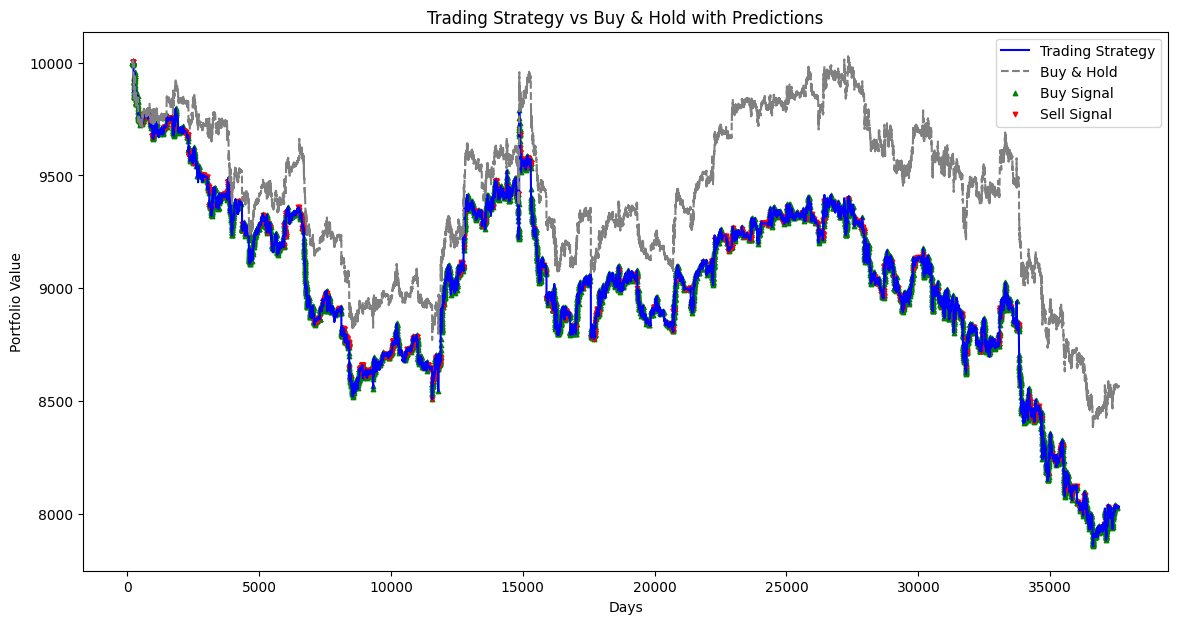

In [181]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

def run_backtest(df, model, initial_capital=10000):
    position = 0
    capital = initial_capital
    returns = []
    buy_and_hold_position = initial_capital / df["close"].iloc[0]  # Starta med att köpa aktier
    buy_and_hold = []
    predictions = []  # Lista för att spara modellens prediktioner

    # Listan av förväntade funktioner (kolumnnamn) baserat på hur du tränade modellen
    expected_features = ["open", "high", "low", "close", "volume", "trade_count", "vwap", 
                         "EMA_9", "EMA_21", "SMA_50", "SMA_200", "MACD", "Signal_Line", "RSI_14",
                         "VWAP", "Volume_Change", "Return", "Close_Lag_1", "Close_Lag_2", "Close_Lag_3"]

    for i in range(len(df)):  # Vi börjar från index 1 eftersom vi vill jämföra varje dag med föregående
        try:
            # Gör en prediktion från modellen om den ska köpa (1), sälja (-1) eller hålla (0)
            feature_data = df.iloc[i].drop(["target", "timestamp", "symbol", "future_return"])  # Ta bort irrelevant data för prediktion
            feature_data = feature_data[expected_features]  # Se till att du har rätt funktioner för prediktion

            # Skapa en DMatrix från värdena och säkerställ att feature-namn är korrekt
            dmatrix = xgb.DMatrix(feature_data.values.reshape(1, -1), feature_names=expected_features)

            prediction = model.predict(dmatrix)[0]  # Förutsäg

            # Avrunda prediktionen till heltal (0, 1 eller 2)
            prediction = round(prediction)

            # Lägg till prediktionen till listan
            predictions.append(prediction)

            # Om modellen säger att vi ska köpa
            if prediction == 2 and position == 0:  # Köp signal
                position = capital / df["close"].iloc[i]  # Köp aktier
                capital = 0  # Förlorar kapitalet i kontanter och investerar det i aktier
            elif prediction == 1 and position > 0:  # Sälj signal
                capital = position * df["close"].iloc[i]  # Sälj aktierna
                position = 0  # Töm positionen

            # Uppdatera kapital och lägg till det i listan
            current_value = capital + (position * df["close"].iloc[i])
            returns.append(current_value)

            # För Buy & Hold, beräkna värdet av aktierna till dagens pris
            buy_and_hold_value = buy_and_hold_position * df["close"].iloc[i]
            buy_and_hold.append(buy_and_hold_value)

        except Exception as e:
            print(f"Error in prediction at index {i}: {e}")
            returns.append(capital)  # Om något går fel, behåll kapitalet som det är
            buy_and_hold.append(buy_and_hold_position * df["close"].iloc[i])

    # Lägg till kolumner för strategins kapital, Buy & Hold och prediktionerna
    df["Strategy Equity"] = returns
    df["Buy & Hold Equity"] = buy_and_hold
    df["Predictions"] = predictions  # Lägg till prediktioner som en kolumn

    return df


# Kör tillbaka strategin och skapa en ny DataFrame
df_with_equity = run_backtest(df_test, model)

# Plotta jämförelsen mellan din trading-strategi, Buy & Hold och prediktionerna
plt.figure(figsize=(14, 7))
plt.plot(df_with_equity["Strategy Equity"], label="Trading Strategy", color='blue')
plt.plot(df_with_equity["Buy & Hold Equity"], label="Buy & Hold", linestyle="--", color='gray')

# Lägg till prediktionerna som ^ för köp och v för sälj
buy_signals = df_with_equity[df_with_equity["Predictions"] == 2]
sell_signals = df_with_equity[df_with_equity["Predictions"] == 1]

# Plot ^ för köp och v för sälj
plt.scatter(buy_signals.index, buy_signals["Strategy Equity"], marker='^', color='green', label='Buy Signal', alpha=1, s=10)
plt.scatter(sell_signals.index, sell_signals["Strategy Equity"], marker='v', color='red', label='Sell Signal', alpha=1, s=10)

plt.title("Trading Strategy vs Buy & Hold with Predictions")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


In [176]:
print(df_with_equity["Predictions"].value_counts())

Predictions
0.0    23273
2.0    11690
1.0     2443
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame
from pytickersymbols import PyTickerSymbols
from datetime import datetime
import xgboost as xgb
import pandas as pd
import numpy as np
import os

def add_features(df_features):
    # 🟢 Exponentiella glidande medelvärden (EMA)
    df_features["EMA_9"] = df_features["close"].ewm(span=9, adjust=False).mean()
    df_features["EMA_21"] = df_features["close"].ewm(span=21, adjust=False).mean()

    # 🟢 Enkel glidande medelvärden (SMA)
    df_features["SMA_50"] = df_features["close"].rolling(window=50).mean()
    df_features["SMA_200"] = df_features["close"].rolling(window=200).mean()

    # 🟢 MACD & Signal Line
    df_features["MACD"] = df_features["EMA_9"] - df_features["EMA_21"]
    df_features["Signal_Line"] = df_features["MACD"].ewm(span=9, adjust=False).mean()

    # 🟢 RSI (Relative Strength Index)
    def calculate_rsi(series, period=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df_features["RSI_14"] = calculate_rsi(df_features["close"])

    # 🟢 VWAP (Volume Weighted Average Price)
    df_features["VWAP"] = (df_features["vwap"] * df_features["volume"]).cumsum() / df_features["volume"].cumsum()

    # 🟢 Volymförändring (% skillnad)
    df_features["Volume_Change"] = df_features["volume"].pct_change()

    # 🟢 Prisskillnad (log-return för stabilare träning)
    df_features["Return"] = np.log(df_features["close"] / df_features["close"].shift(1))

    # 🟢 Lag-features (Senaste 3 stängningspriser)
    df_features["Close_Lag_1"] = df_features["close"].shift(1)
    df_features["Close_Lag_2"] = df_features["close"].shift(2)
    df_features["Close_Lag_3"] = df_features["close"].shift(3)

    # 🟢 Målvariabel (Target Variable)
    df_features["future_return"] = df_features["close"].pct_change(5).shift(-5)  # 5 perioder framåt
    threshold = 0.005  # 0.5% förändring som gräns

    # Justera målvärdena så de passar XGBoost (0 = håll, 1 = köp, 2 = sälj)
    df_features["target"] = 0  # Håll som standard
    df_features.loc[df_features["future_return"] > threshold, "target"] = 1  # Köp
    df_features.loc[df_features["future_return"] < -threshold, "target"] = 2  # Sälj

    # Ta bort rader med NaN-värden efter beräkning av indikatorer
    df_features.dropna(inplace=True)

    return df_features

def train(model, stock_data):
    # Förbered data för träning
    X = stock_data.drop(columns=["target", "timestamp", "symbol", "future_return"]) # Feature columns
    y = stock_data['target']  # Target variable

    # Dela upp i träning och test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Vikter för att balansera dataset
    target_counts = y_train.value_counts()
    num_0 = target_counts[0]  # Håll
    weights = y_train.map(lambda x: num_0 / target_counts[x])

    # Skapa DMatrix med vikter
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Hyperparametrar
    params = {
        "objective": "multi:softmax",
        "num_class": 3,  # Antal klasser
        "max_depth": 6,
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "eval_metric": "mlogloss",
    }

    # Träna modellen
    num_round = 100
    model = xgb.train(params, dtrain, num_round, xgb_model=model)  # Träna med den gemensamma modellen

    # Gör prediktioner på testdata
    y_pred = model.predict(dtest)

    # Utvärdera modellen
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for stock: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return model

# Keys
API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

stock_client = StockHistoricalDataClient(API_KEY,  SECRET_KEY)
trading_client = TradingClient(API_KEY, SECRET_KEY)

stock_data = PyTickerSymbols()
nasdaq_100 = stock_data.get_stocks_by_index('NASDAQ 100')

model = None
for stock in nasdaq_100:
    # Get the stock bars
    request_params = StockBarsRequest(symbol_or_symbols=[stock["symbol"]], timeframe=TimeFrame.Minute, start=datetime(2024, 3, 14), end=datetime(2025, 3, 14))
    bars = stock_client.get_stock_bars(request_params)

    # Flatten the dictionary into a DataFrame
    df = pd.DataFrame(bars[stock["symbol"]])

    # Extrahera endast värdena från tuple-paren
    df = df.map(lambda x: x[1])  # Tar bara det andra elementet i tuple:n

    # Sätt kolumnnamn
    df.columns = ["symbol", "timestamp", "open", "high", "low", "close", "volume", "trade_count", "vwap"]

    df_features = add_features(df)

    model = train(model, df_features)

model.save_model("nasdaq100_model.model")  # Spara modellen för senare användning
